# text2poem
End-to-End Poetry Generation from a list of topics using [T5: Text-To-Text Transfer Transformer](https://arxiv.org/abs/1910.10683)  
Author: [Harshit Varma](https://github.com/hrshtv)

## To-do:
- [ ] Tune the batch size
- [ ] Tune the number of epochs

## Install Dependencies

In [1]:
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 7.8MB/s 
     |████████████████████████████████| 3.3MB 49.7MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 
     |████████████████████████████████| 1.1MB 7.5MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [474]:
%reset -f

## Import Libraries

In [475]:
# General libraries
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [476]:
torch.cuda.empty_cache()

In [477]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [478]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/topics_250_top_authors.csv"
MODEL_NAME = "t5-base"

SEED = 0

# Specified in the number of tokens
INP_MAX_LEN = 128
OUT_MAX_LEN = 512

TRAIN_BATCH_SIZE = 4

N_EPOCHS = 15
LR = 1e-4

PREFIX = "poemify: " # The T5 prefix to append to the inputs
SENT_SEP = "|"
TOPIC_SEP = ", "

In [479]:
# Set random seeds and make pytorch deterministic for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Helper Functions

In [480]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Custom Dataset

In [481]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output


    def __len__(self):
        return len(self.out_txt)


    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids"  : source_ids, 
            "source_mask" : source_mask, 
            "target_ids"  : target_ids,
            "target_mask" : target_mask
        }

## Data Handlers

In [482]:
def replaceSep(text, sep = SENT_SEP):
    """ Replaces all multiline breaks by a single sep everywhere, as T5Tokenizer just replaces '\n' by a blank space """
    corrupted_sentences = text.split("\n")
    sentences = [s.strip() for s in corrupted_sentences if len(s.strip()) > 1]
    text = sep.join(sentences)
    return text

In [483]:
def loadDF(path, n_rows = None, prefix = PREFIX):
    """ Loads the CSV data, converts it to the specified format, and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")

    # Drop the NaN rows (if any)
    df.dropna(inplace = True)

    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]

    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)

    # Add a suitable prefix to the text input
    df["input"] = prefix + df["input"]

    # Truncate the dataset if specified
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Replace newlines in the poem
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)
    
    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [484]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)

    # Create Dataloaders
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)

    return dl_train, dl_val

## Train and Validate Functions

In [485]:
def train(tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE)
        source_mask = batch["source_mask"].to(DEVICE)
        target_mask = batch["target_mask"].to(DEVICE)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
        
        loss_batches.append(loss.item())

        # Compute gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()

    # Average epoch loss:
    avg_epoch_loss = sum(loss_batches) / len(loss_batches)

    return avg_epoch_loss

## Generation

In [486]:
def genBeam(topics, min_length, max_length, rep_penalty, n_beams, already_formatted = False):

    if not already_formatted:   
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        num_beams = n_beams,
        no_repeat_ngram_size = 4,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split(SENT_SEP)
    for s in sentences:
        print(s.strip())

    return gen

In [487]:
def genSample(topics, min_length, max_length, rep_penalty, temp = 1, already_formatted = False):

    if not already_formatted:
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        temperature = temp,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split(SENT_SEP)
    for s in sentences:
        print(s.strip())

    return gen

## Main

### Tokenizer

In [488]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [489]:
example_text = "Far far away, behind the word mountains, far from the countries Vokalia and Consonantia, there live the blind texts.\nFar far away, behind the word mountains, far from the countries Vokalia and Consonantia, there live the blind texts"
example_input_ids = tokenizer(
    example_text,
    return_tensors = "pt"
).input_ids[0]
print(len(example_input_ids))
example_decoded = [tokenizer.decode(i, skip_special_tokens = True, clean_up_tokenization_spaces = True) for i in example_input_ids]
print(example_decoded)

56
['Far', 'far', 'away', ',', 'behind', 'the', 'word', 'mountains', ',', 'far', 'from', 'the', 'countries', 'Vo', 'k', 'alia', 'and', 'Cons', 'on', 'anti', 'a', ',', 'there', 'live', 'the', 'blind', 'texts', '.', 'Far', 'far', 'away', ',', 'behind', 'the', 'word', 'mountains', ',', 'far', 'from', 'the', 'countries', 'Vo', 'k', 'alia', 'and', 'Cons', 'on', 'anti', 'a', ',', 'there', 'live', 'the', 'blind', 'texts', '</s>']


### Loading the Data

In [490]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = PREFIX)
print(len(df), len(df_train), len(df_val))

566 561 5


In [491]:
display(df)

,output,input
0,I wage not any feud with Death|For changes wro...,"poemify: shattered stalks, lower life, human w..."
1,Again at Christmas did we weave|The holly roun...,"poemify: single tear, silent snow, quiet sense..."
2,"Calm is the morn without a sound,|Calm as to s...","poemify: deep peace, dead calm, calmer grief, ..."
3,"Risest thou thus, dim dawn, again,|And howlest...","poemify: disastrous day, joyless gray, hideous..."
4,"Dark house, by which once more I stand|Here in...","poemify: unlovely street, street breaks, life ..."
...,...,...
561,"From low to high doth dissolution climb,|And s...","poemify: over-anxious care, awful notes, melan..."
562,"The power of Armies is a visible thing,|Formal...","poemify: fatal place, brave people, strong win..."
563,Most sweet it is with unuplifted eyes|To pace ...,"poemify: happy tone, ideal scene, internal hea..."
564,Beneath these fruit-tree boughs that shed|Thei...,"poemify: happiest guest, voiceless form, unclo..."


In [492]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

141 2


In [493]:
def countTokens(text):
    input_ids = tokenizer(
        text,
        return_tensors = "pt"
    ).input_ids[0]
    return len(input_ids)

In [494]:
df["input_length"] = df["input"].apply(countTokens)
df["output_length"] = df["output"].apply(countTokens)

In [495]:
# Use this to select INP_MAX_LEN and OUT_MAX_LEN
print("Input Length (in tokens) Statistics")
print(df["input_length"].describe())
print()
print("Output Length (in tokens) Statistics")
print(df["output_length"].describe())

Input Length (in tokens) Statistics
count    566.000000
mean      44.632509
std       11.222257
min       13.000000
25%       36.250000
50%       43.000000
75%       52.000000
max       91.000000
Name: input_length, dtype: float64

Output Length (in tokens) Statistics
count    566.000000
mean     227.461131
std       91.601683
min       73.000000
25%      166.000000
50%      201.500000
75%      287.000000
max      497.000000
Name: output_length, dtype: float64


### Loading the Model

In [496]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [497]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 222,903,552 trainable and 0 frozen parameters


### Optimization

In [498]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [499]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}")
    loss_epoch = train(tokenizer, model, dl_train, optimizer)
    losses.append(loss_epoch)

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15


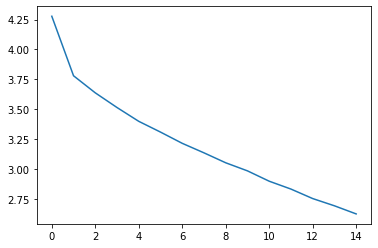

In [500]:
plt.plot(range(len(losses)), losses)
plt.show()

In [501]:
val_list = df_val["input"].tolist()
for inp in val_list:
    genSample(inp, 0, 500, 1.2, 0.9, True)
    print("\n")

Come and see,
And let me not hurt
None of mine do harm;
I know that I am free.
And let me not,- I tell our children
Yet a thousand times
Dad I tell you, let me lie
Where ye are free,
As long as they should go
Sitting there in the road,
And I am learning to look
From my white hair:
And then I will be left by
Then weep that the wind's wake
Of my happiness is free;
And smile that it is
Long before yonder rose,
But never sleep, and never sleep


I sing and pray that eternal god of thee
Who can bring thee to life?
For th'almighty thunders, in his sweeping tempest flies
I send out brave decrees,
But also a warning,
When the dark is gone,
Thy nameless poisoned arrow
Strangellizes the lake so far away;
We wish that a clenched gate or gate
To rejoice upon thee!
What yet th'almighty thunders are done


Do not share that with us all,
A place of pleasant mirth in a shady past,
Try our tender thoughts, and we shall feel
That they come together again.
Arise from above, whispered with happy eyes,
A v

In [502]:
for inp in val_list:
    genBeam(inp, min_length = 100, max_length = 500, rep_penalty = 1.2, n_beams = 2, already_formatted = True)
    print("\n\n")

I am happy, I am white, I am green,
And I'm not in harm's way,
It's a bright key, I'm happy,
I'm a green plain,
I think I'm going to be free.
I'll be the one I'm the one I love,
And the other thousand I love.
I love you more than I love you.
I hate you, I've known you before:
I've loved you, I know that you are free



I hear the sweeping tempest flies,
And th'almighty thunders, and th'all thunders,
Ah, th'eternal god! th'ascension flies!
I hear the throne, the deaf adder,
And the throng of th' grandeur melts,
And bold decrees,
The words of a man whose name is borne,
And that he is the king of king.
Then, he who hath died,
He who cast his poisoned arrows,
Than he who breathed thee,
Is thee in thee who breathed in thee



I heard a sylphic sound,
A pleasant mirth in the shady past;
A voice of tenderness,
A dulcet voice in the air,
A bright voice, a dulcet voice,
An eye on me,
A voice that sings with happy eyes;
A glimmer of light,
At a moment's ebb and flow;
An instant's gleaming smile,

In [518]:
gen = genSample(["frosty white", "candy cane", "jolly carols", "celebration", "gingerbread", "mistletoe", "snowmen", "snowflakes"], 
                0, 200, 1.4, 0.9)

I waken in a frosty white sweater,
And find out exactly how it looks to melt:
Browsing from the snow,
This has become my favorite ornament of late-January.
Leal and lemon trees;
But not this one is gone.
The first snowden bells fly,
Never a door open to reveal them,
Of snowmen made of snow;
And bare bones defrosted with jolly carols.
Snowmen in mistletoe,
And sometimes people gather together.
I have loved these tulip! To make some snowflakes,
And little gingerbread,
And then I crouched and crowed.
Or perhaps that's just me


In [513]:
gen = genSample(["dark woods", "broken glass", "weeping river", "full moon", "howling wolves", "freezing air", "sad"], 
                0, 200, 1.4, 0.9)

I am in the dark woods of a field
Stripped by snow and logs,
Darkness falls on the fields,
And the times slow.
That'll not come back until the new moon
Of the weeping river shall pass;
I will not forget that at last here in the wettering rain:
The howling wolves,
The wolves with their bell-blades,
In the freezing air,
The howling wolves are gone.
As my heart breaking silence...the sad soundheads of the dry land


Come and visit me at the weeping river.
Come on, my friends!
Come and gather us in the dark woods,
and find us out together in peace,
Raised in broken glass, near the freezing air,
Then hurry up!
Come by again:
Come, my friends!
Come and meet us in the evening.
Come &amp; help us with our lives-
Come, come and join us in the hope of happiness
Deeper than where we are all together.
Come here to look for Me!
Come over and hear the howling wolves?
Come away in the dark woods

## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```